In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, power_transform
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import sklearn
import phik
from phik.binning import bin_data
import itertools
import mlflow
mlflow.set_tracking_uri("./mlruns")
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
    roc_curve
)

In [2]:
mlflow.set_tracking_uri("http://84.201.180.128:8000/")
pd.options.display.max_columns = None
sklearn.set_config(transform_output='pandas')
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv(r'E:\projects\bankchurn\data\Churn_Modelling.csv')

data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
6,7,15592531,Bartlett,822,NaN,Male,50.0,7,0.00,2,1.0,1.0,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29.0,4,115046.74,4,1.0,0.0,119346.88,1
8,9,15792365,He,501,France,Male,44.0,4,142051.07,2,0.0,NaN,74940.50,0
9,10,15592389,H?,684,France,Male,NaN,2,134603.88,1,1.0,1.0,71725.73,0


In [4]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [5]:
data.isnull().sum()

CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
data.dropna(inplace=True)

data.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
cols_list = data.columns.to_list()
n_unique = [data[col].nunique() for col in cols_list]
types = data.dtypes

pd.DataFrame({'dtpye': types, 'n_uniqs': n_unique})

,dtpye,n_uniqs
CreditScore,int64,460
Geography,object,3
Gender,object,2
Age,float64,73
Tenure,int64,11
Balance,float64,6379
NumOfProducts,int64,4
HasCrCard,float64,2
IsActiveMember,float64,2
EstimatedSalary,float64,9995


In [8]:
for col in ['HasCrCard', 'IsActiveMember']:
    data[col] = data[col].astype('int')

data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [9]:
eda_data = data.copy()

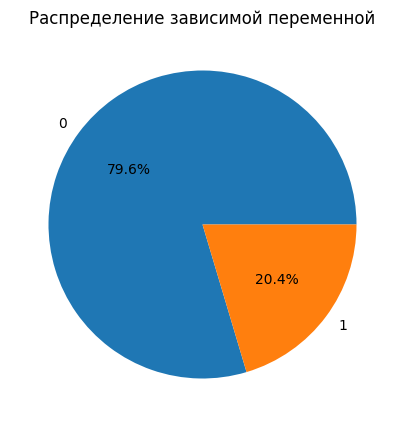

In [10]:
fig, axes = plt.subplots(figsize=(10, 5))
ax = plt.pie(eda_data['Exited'].value_counts(), labels=eda_data['Exited'].value_counts().index, autopct="%.1f%%",)
plt.title('Распределение зависимой переменной')
plt.show()

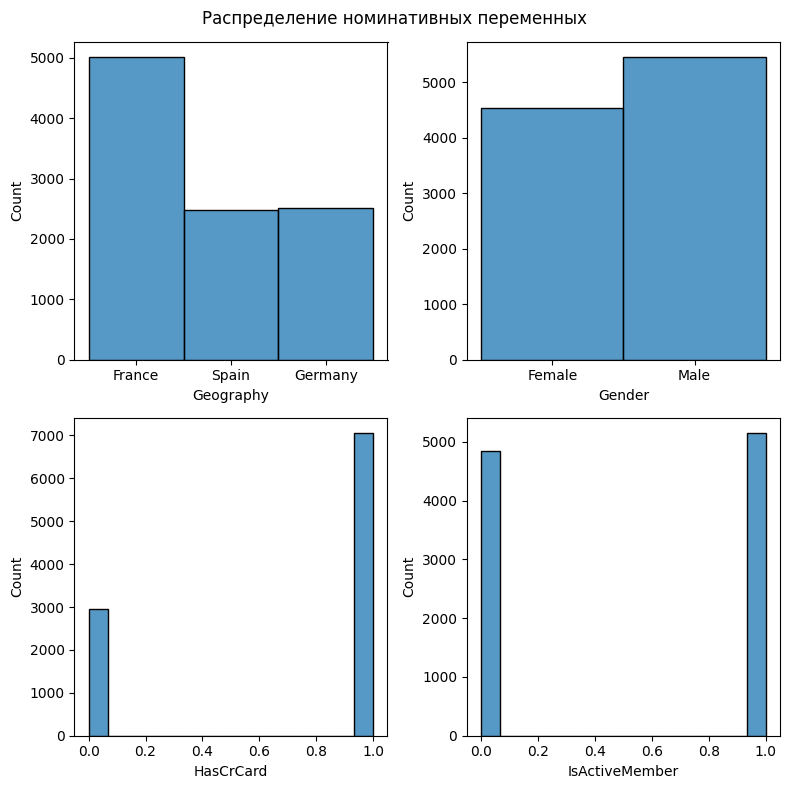

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
plt.suptitle('Распределение номинативных переменных')

sns.histplot(data=eda_data, x='Geography', ax=axes[0][0])
sns.histplot(data=eda_data, x='Gender', ax=axes[0][1])
sns.histplot(data=eda_data, x='HasCrCard', ax=axes[1][0])
sns.histplot(data=eda_data, x='IsActiveMember', ax=axes[1][1])

plt.tight_layout()
plt.show()

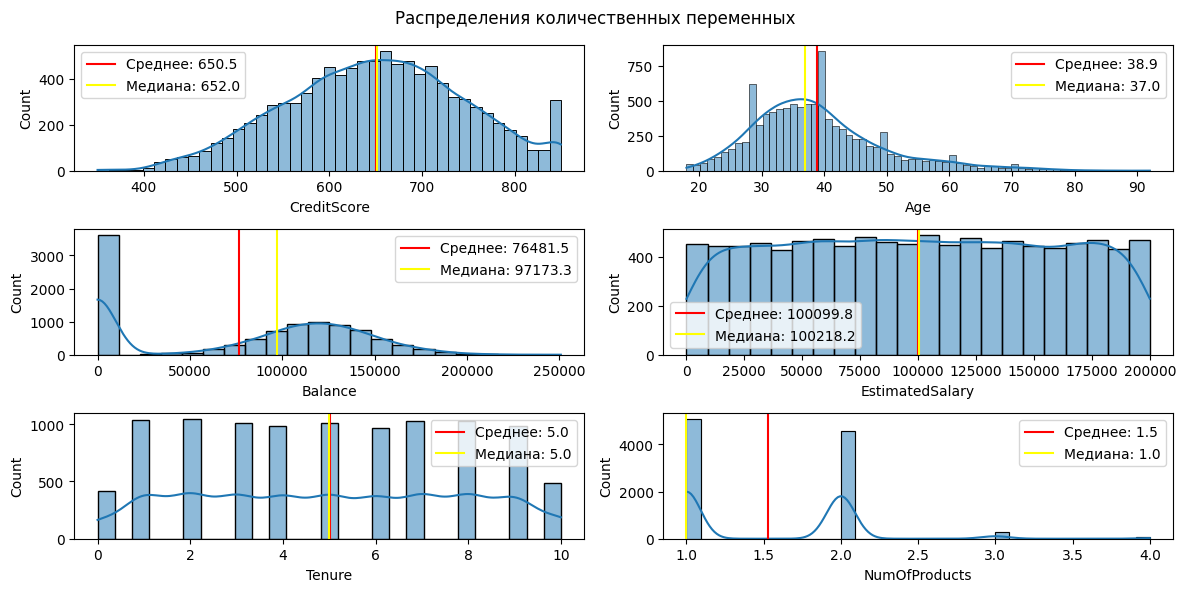

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))
fig.suptitle('Распределения количественных переменных')

ax1 = sns.histplot(data=eda_data, x='CreditScore', kde=True, ax=axes[0][0])
ax1.axvline(x=eda_data['CreditScore'].mean(), color='red', label=f"Среднее: {np.round(eda_data['CreditScore'].mean(), 1)}")
ax1.axvline(x=eda_data['CreditScore'].median(), color='yellow', label=f"Медиана: {np.round(eda_data['CreditScore'].median(), 1)}")
ax1.legend()

ax2 = sns.histplot(data=eda_data, x='Age', kde=True, ax=axes[0][1])
ax2.axvline(x=eda_data['Age'].mean(), color='red', label=f"Среднее: {np.round(eda_data['Age'].mean(), 1)}")
ax2.axvline(x=eda_data['Age'].median(), color='yellow', label=f"Медиана: {np.round(eda_data['Age'].median(), 1)}")
ax2.legend()

ax3 = sns.histplot(data=eda_data, x='Balance', kde=True, ax=axes[1][0])
ax3.axvline(x=eda_data['Balance'].mean(), color='red', label=f"Среднее: {np.round(eda_data['Balance'].mean(), 1)}")
ax3.axvline(x=eda_data['Balance'].median(), color='yellow', label=f"Медиана: {np.round(eda_data['Balance'].median(), 1)}")
ax3.legend()

ax4 = sns.histplot(data=eda_data, x='EstimatedSalary', kde=True, ax=axes[1][1])
ax4.axvline(x=eda_data['EstimatedSalary'].mean(), color='red', label=f"Среднее: {np.round(eda_data['EstimatedSalary'].mean(), 1)}")
ax4.axvline(x=eda_data['EstimatedSalary'].median(), color='yellow', label=f"Медиана: {np.round(eda_data['EstimatedSalary'].median(), 1)}")
ax4.legend()

ax5 = sns.histplot(data=eda_data, x='Tenure', kde=True, ax=axes[2][0])
ax5.axvline(x=eda_data['Tenure'].mean(), color='red', label=f"Среднее: {np.round(eda_data['Tenure'].mean(), 1)}")
ax5.axvline(x=eda_data['Tenure'].median(), color='yellow', label=f"Медиана: {np.round(eda_data['Tenure'].median(), 1)}")
ax5.legend()

ax6 = sns.histplot(data=eda_data, x='NumOfProducts', kde=True, ax=axes[2][1])
ax6.axvline(x=eda_data['NumOfProducts'].mean(), color='red', label=f"Среднее: {np.round(eda_data['NumOfProducts'].mean(), 1)}")
ax6.axvline(x=eda_data['NumOfProducts'].median(), color='yellow', label=f"Медиана: {np.round(eda_data['NumOfProducts'].median(), 1)}")
ax6.legend()

plt.tight_layout()
plt.show()

In [13]:
num_power = eda_data[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']].copy()

In [14]:
pt = PowerTransformer(method='yeo-johnson')

In [15]:
for col in num_power:
    num_power[col] = pt.fit_transform(num_power[[col]])

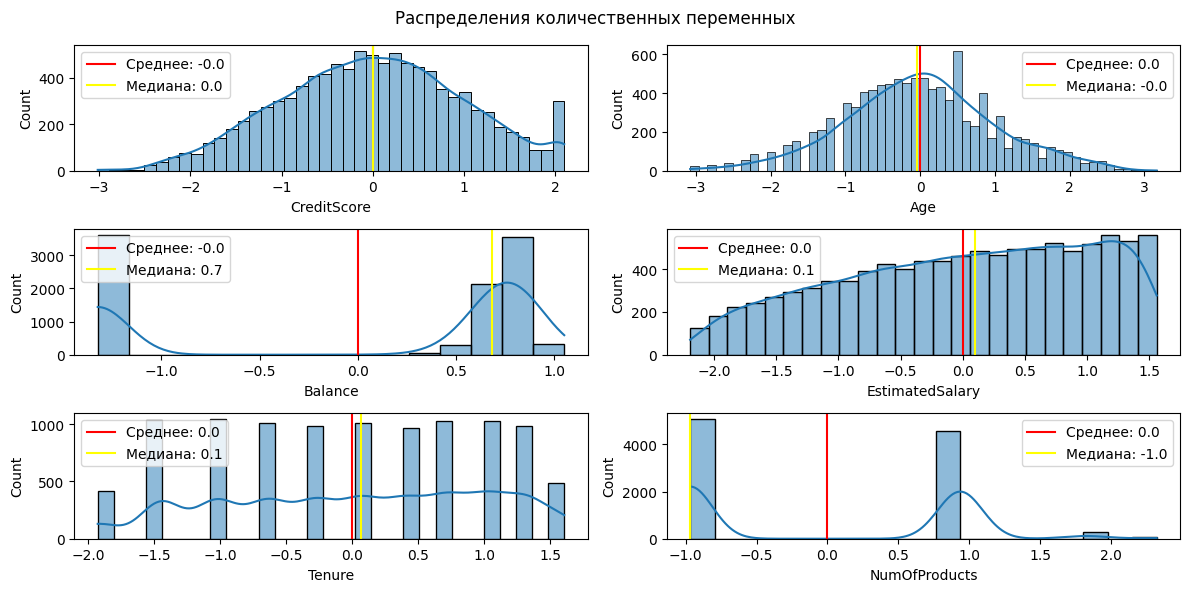

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))
fig.suptitle('Распределения количественных переменных')

ax1 = sns.histplot(data=num_power, x='CreditScore', kde=True, ax=axes[0][0])
ax1.axvline(x=num_power['CreditScore'].mean(), color='red', label=f"Среднее: {np.round(num_power['CreditScore'].mean(), 1)}")
ax1.axvline(x=num_power['CreditScore'].median(), color='yellow', label=f"Медиана: {np.round(num_power['CreditScore'].median(), 1)}")
ax1.legend()

ax2 = sns.histplot(data=num_power, x='Age', kde=True, ax=axes[0][1])
ax2.axvline(x=num_power['Age'].mean(), color='red', label=f"Среднее: {np.round(num_power['Age'].mean(), 1)}")
ax2.axvline(x=num_power['Age'].median(), color='yellow', label=f"Медиана: {np.round(num_power['Age'].median(), 1)}")
ax2.legend()

ax3 = sns.histplot(data=num_power, x='Balance', kde=True, ax=axes[1][0])
ax3.axvline(x=num_power['Balance'].mean(), color='red', label=f"Среднее: {np.round(num_power['Balance'].mean(), 1)}")
ax3.axvline(x=num_power['Balance'].median(), color='yellow', label=f"Медиана: {np.round(num_power['Balance'].median(), 1)}")
ax3.legend()

ax4 = sns.histplot(data=num_power, x='EstimatedSalary', kde=True, ax=axes[1][1])
ax4.axvline(x=num_power['EstimatedSalary'].mean(), color='red', label=f"Среднее: {np.round(num_power['EstimatedSalary'].mean(), 1)}")
ax4.axvline(x=num_power['EstimatedSalary'].median(), color='yellow', label=f"Медиана: {np.round(num_power['EstimatedSalary'].median(), 1)}")
ax4.legend()

ax5 = sns.histplot(data=num_power, x='Tenure', kde=True, ax=axes[2][0])
ax5.axvline(x=num_power['Tenure'].mean(), color='red', label=f"Среднее: {np.round(num_power['Tenure'].mean(), 1)}")
ax5.axvline(x=num_power['Tenure'].median(), color='yellow', label=f"Медиана: {np.round(num_power['Tenure'].median(), 1)}")
ax5.legend()

ax6 = sns.histplot(data=num_power, x='NumOfProducts', kde=True, ax=axes[2][1])
ax6.axvline(x=num_power['NumOfProducts'].mean(), color='red', label=f"Среднее: {np.round(num_power['NumOfProducts'].mean(), 1)}")
ax6.axvline(x=num_power['NumOfProducts'].median(), color='yellow', label=f"Медиана: {np.round(num_power['NumOfProducts'].median(), 1)}")
ax6.legend()

plt.tight_layout()
plt.show()

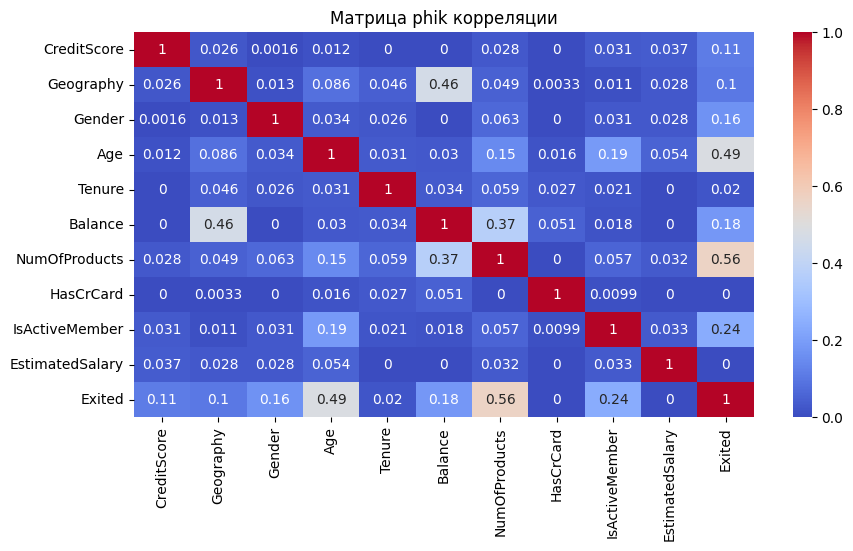

In [17]:
fig, axes = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(eda_data.phik_matrix(interval_cols=['CreditScore', 'Age', 'Balance', 'EstimatedSalary']), annot=True, cmap='coolwarm')
ax.set_title('Матрица phik корреляции')
plt.show()

In [18]:
corr_data = eda_data[['Geography', 'Balance', 'NumOfProducts', 'Exited']].copy()

In [19]:
data_binned, binning_dict = bin_data(corr_data, cols=['Balance', 'NumOfProducts'], retbins=True)

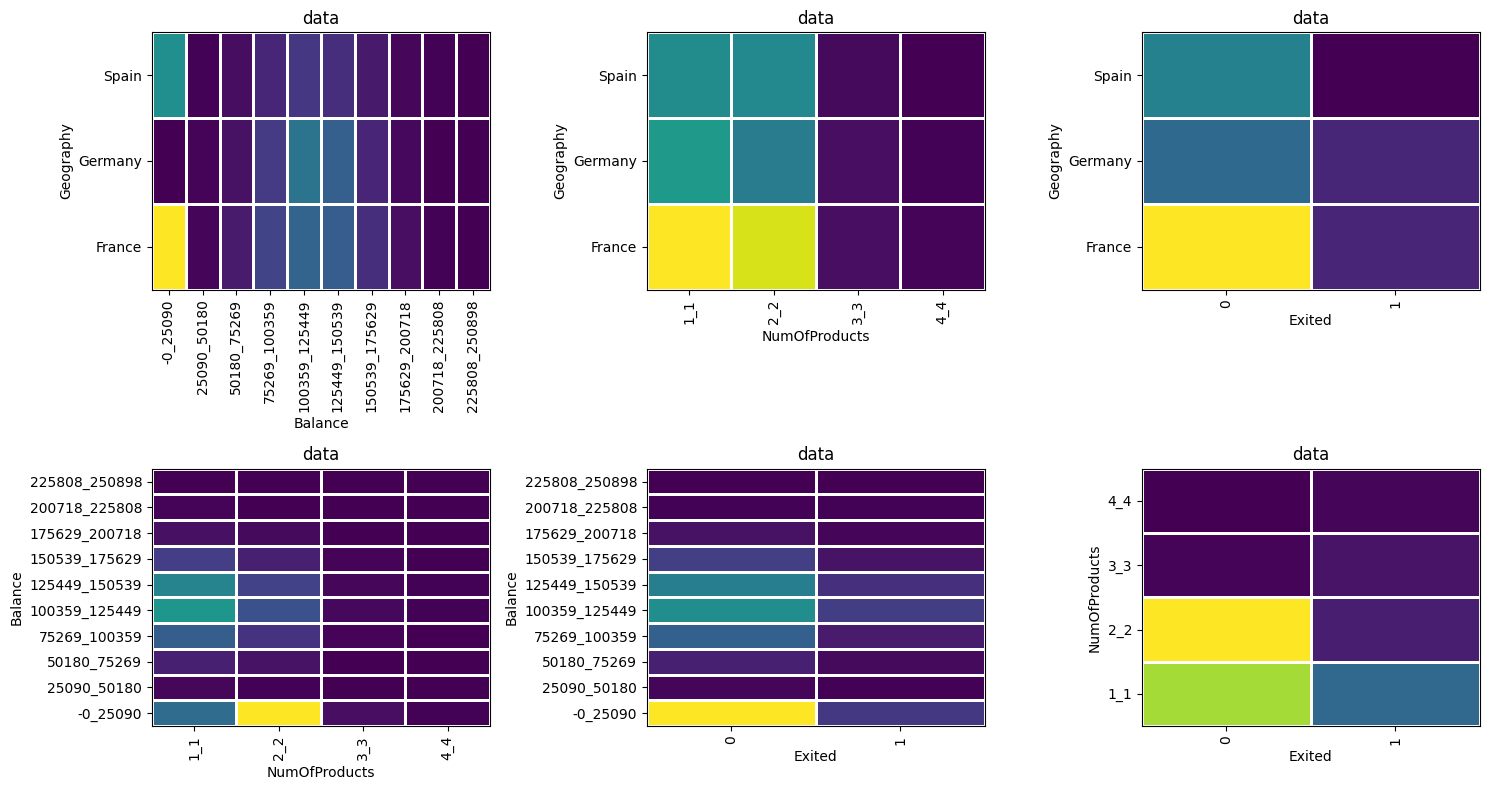

In [20]:
plt.rc('text', usetex=False)

n=0
for i in range(corr_data.shape[1]):
    n=n+i
    
ncols=3
nrows=int(np.ceil(n/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(15,4*nrows))
ndecimals = 0

for i, comb in enumerate(itertools.combinations(data_binned.columns.values, 2)):
    
    c = int(i%ncols)
    r = int((i-c)/ncols )

    # get data
    c0, c1 = comb
    datahist = data_binned.groupby([c0,c1])[c0].count().to_frame().unstack().fillna(0)
    datahist.columns = datahist.columns.droplevel()
    
    # plot data
    img = axes[r][c].pcolormesh(datahist.values, edgecolor='w', linewidth=1)
    
    # axis ticks and tick labels
    if c0 in binning_dict.keys():
        ylabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c0][i][0], binning_dict[c0][i][1])
                   for i in range(len(binning_dict[c0]))]
    else:
        ylabels = datahist.index

    if c1 in binning_dict.keys():        
        xlabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c1][i][0], binning_dict[c1][i][1])
                    for i in range(len(binning_dict[c1]))]
    else:
        xlabels = datahist.columns
    
    # axis labels
    axes[r][c].set_yticks(np.arange(len(ylabels)) + 0.5)
    axes[r][c].set_xticks(np.arange(len(xlabels)) + 0.5)
    axes[r][c].set_xticklabels(xlabels, rotation='vertical')
    axes[r][c].set_yticklabels(ylabels, rotation='horizontal')    
    axes[r][c].set_xlabel(datahist.columns.name)
    axes[r][c].set_ylabel(datahist.index.name)    
    axes[r][c].set_title('data')
    
plt.tight_layout()

In [21]:
MeanPerHuman = eda_data.groupby(['Geography', 'Gender', 'Exited']).agg(avgSalary=('EstimatedSalary', 'mean')).reset_index()

MeanPerHuman

,Geography,Gender,Exited,avgSalary
0,France,Female,0,98493.337808
1,France,Female,1,103626.025065
2,France,Male,0,99793.810083
3,France,Male,1,103193.839686
4,Germany,Female,0,103987.042242
5,Germany,Female,1,99884.458728
6,Germany,Male,0,101181.577505
7,Germany,Male,1,96581.511117
8,Spain,Female,0,98923.772252
9,Spain,Female,1,107544.095758


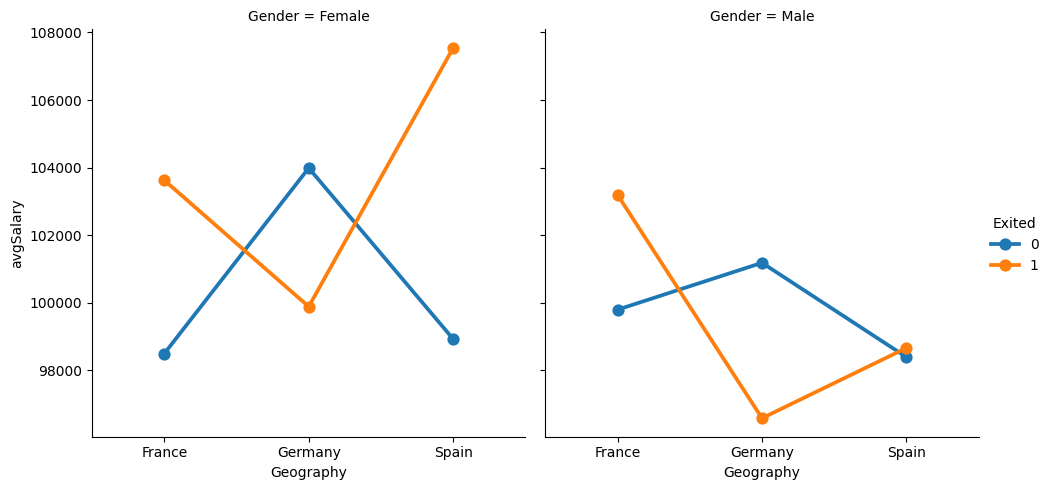

In [22]:
sns.catplot(x=MeanPerHuman.Geography, y=MeanPerHuman.avgSalary, hue=MeanPerHuman.Exited, col=MeanPerHuman.Gender, kind='point')
plt.show()

In [23]:
exited = eda_data.groupby(['Geography', 'Gender', 'Exited',]).agg(ExitedCounter=('Exited', 'count')).reset_index()

exited

,Geography,Gender,Exited,ExitedCounter
0,France,Female,0,1802
1,France,Female,1,460
2,France,Male,0,2400
3,France,Male,1,350
4,Germany,Female,0,745
5,Germany,Female,1,448
6,Germany,Male,0,950
7,Germany,Male,1,367
8,Spain,Female,0,857
9,Spain,Female,1,231


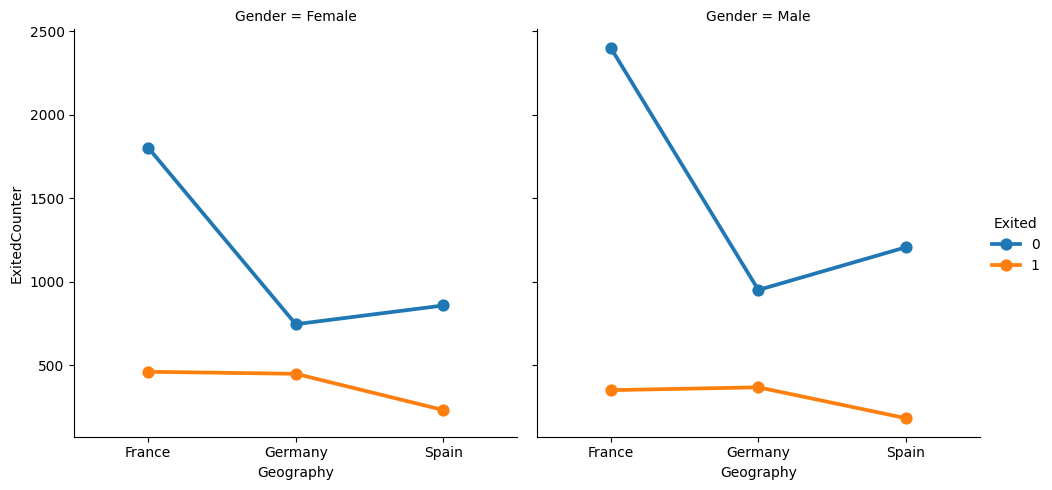

In [24]:
sns.catplot(y=exited.ExitedCounter, x=exited.Geography, hue=exited.Exited, col=exited.Gender, kind='point')
plt.show()

In [25]:
CScore = eda_data.groupby(['Geography', 'Gender', 'Exited']).agg(meanCscore=('CreditScore', 'mean')).reset_index()

CScore

,Geography,Gender,Exited,meanCscore
0,France,Female,0,650.614872
1,France,Female,1,643.897826
2,France,Male,0,651.609583
3,France,Male,1,639.308571
4,Germany,Female,0,654.514094
5,Germany,Female,1,650.732143
6,Germany,Male,0,652.278947
7,Germany,Male,1,644.313351
8,Spain,Female,0,653.264877
9,Spain,Female,1,645.363636


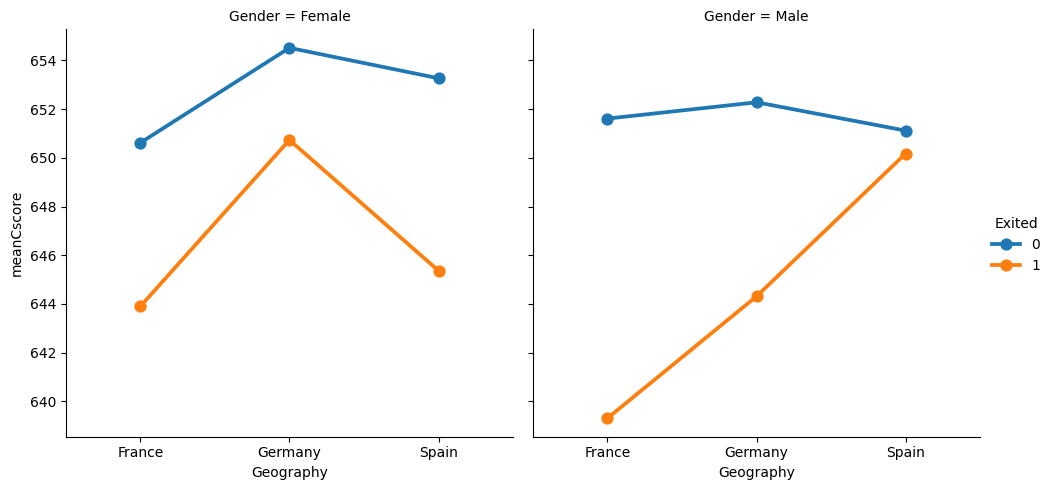

In [26]:
sns.catplot(y=CScore.meanCscore, x=CScore.Geography, hue=CScore.Exited, col=CScore.Gender, kind='point')
plt.show()

In [27]:
Ccard = eda_data.groupby([ 'Geography', 'HasCrCard', 'Exited']).agg(avgCounter=('Exited', 'count')).reset_index()

Ccard

,Geography,HasCrCard,Exited,avgCounter
0,France,0,0,1229
1,France,0,1,241
2,France,1,0,2973
3,France,1,1,569
4,Germany,0,0,481
5,Germany,0,1,237
6,Germany,1,0,1214
7,Germany,1,1,578
8,Spain,0,0,621
9,Spain,0,1,135


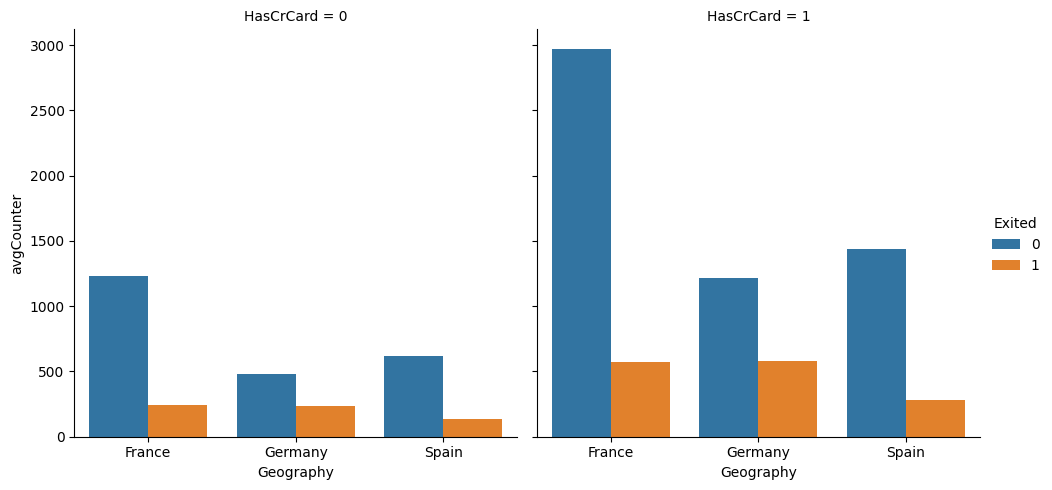

In [28]:
sns.catplot(x=Ccard.Geography, y=Ccard.avgCounter, hue=Ccard.Exited, col=Ccard.HasCrCard, kind='bar')
plt.show()

In [29]:
Pnumber = eda_data.groupby(['NumOfProducts', 'Exited']).agg(Count=('Exited', 'count')).reset_index()

Pnumber

,NumOfProducts,Exited,Count
0,1,0,3674
1,1,1,1409
2,2,0,4240
3,2,1,349
4,3,0,46
5,3,1,220
6,4,1,60


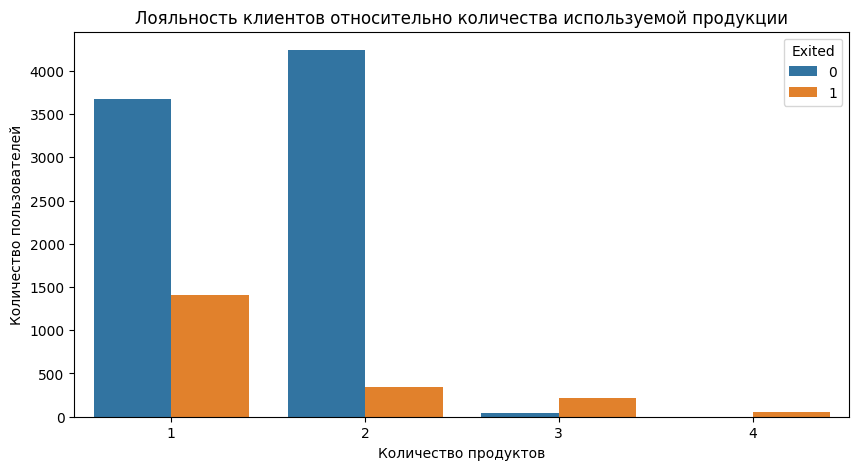

In [30]:
fig, axis = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x=Pnumber.NumOfProducts, y=Pnumber.Count, hue=Pnumber.Exited)
ax.set_xlabel('Количество продуктов')
ax.set_ylabel('Количество пользователей')
ax.set_title('Лояльность клиентов относительно количества используемой продукции')
plt.show()

In [31]:
Tnumber = eda_data.groupby(['Tenure', 'Exited']).agg(Count=('Exited', 'count')).reset_index()

Tnumber

,Tenure,Exited,Count
0,0,0,318
1,0,1,95
2,1,0,803
3,1,1,232
4,2,0,845
5,2,1,201
6,3,0,796
7,3,1,214
8,4,0,786
9,4,1,203


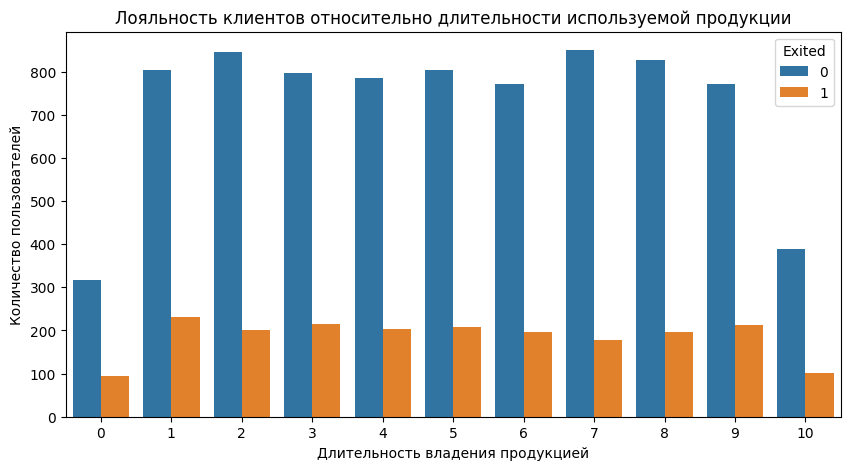

In [32]:
fig, axis = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x=Tnumber.Tenure, y=Tnumber.Count, hue=Tnumber.Exited)
ax.set_xlabel('Длительность владения продукцией')
ax.set_ylabel('Количество пользователей')
ax.set_title('Лояльность клиентов относительно длительности используемой продукции')
plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Exited', axis=1), data['Exited'], stratify=data['Exited'], test_size=.2, random_state=42)

In [34]:
cat_cols = X_train.select_dtypes(include='object').columns.to_list()
num_cols = X_train.select_dtypes(exclude='object').columns.to_list()

In [35]:
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

In [36]:
num_pipe = Pipeline([
    ('pt', PowerTransformer(method='yeo-johnson'))
])

In [37]:
transformer =  ColumnTransformer(transformers=([
    ('cat_pipe', cat_pipe, cat_cols),
    ('num_pipe', num_pipe, num_cols)
]))

In [38]:
ml_pipe = Pipeline([
    ('transformer', transformer),
    ('model', XGBClassifier())
])

In [39]:
ml_pipe.fit(X_train, y_train)

,steps,"[('transformer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_pipe', ...), ('num_pipe', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
def report_metrics(mlflow, y_test, y_pred, y_proba, sufix):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred) 
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy_{sufix}: {accuracy}")
    print(f"Precision_{sufix}: {precision}")
    print(f"Recall_{sufix}: {recall}")
    print(f"F1 Score_{sufix}: {f1}")
    print(f"ROC AUC_{sufix}: {roc_auc}")
    print(f"Confusion Matrix_{sufix}:\n", cm)
    print(f"Balanced Accuracy_{sufix}: {balanced_accuracy}")
    
    mlflow.log_metric(f"accuracy_{sufix}", accuracy)
    mlflow.log_metric(f"precision_{sufix}", precision)
    mlflow.log_metric(f"recall_{sufix}", recall)
    mlflow.log_metric(f"f1_score_{sufix}", f1)
    mlflow.log_metric(f"roc_auc_{sufix}", roc_auc)
    mlflow.log_metric(f"balanced_accuracy_{sufix}", balanced_accuracy)
    mlflow.log_text(f"Confusion Matrix:\n{cm}", f"confusion_matrix_{sufix}.txt")

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(30, 20))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    mlflow.log_figure(plt.gcf(), f"roc_curve_{sufix}.png")
    plt.close()
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    mlflow.log_figure(plt.gcf(), f"confusion_matrix_{sufix}.png")
    plt.close()

In [41]:
def mlflow_run(best_pipeline, best_params, X_test, y_test):
    mlflow.log_params(best_params)

    y_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]

    report_metrics(mlflow, y_test, y_pred, y_proba, 'ml')

    mlflow.sklearn.log_model(best_pipeline, "model_pipeline")


    try:
        importances = best_pipeline.feature_importances_
        feature_names = X_test.columns.to_list()
    except:
        importances = best_pipeline.named_steps['model'].feature_importances_
        feature_names = best_pipeline.named_steps['transformer'].get_feature_names_out()


    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    feat_imp_df = feat_imp_df[feat_imp_df['importance'] > 0].head(40)
    total_importance = feat_imp_df['importance'].sum()
    feat_imp_df['importance_fraction'] = feat_imp_df['importance'] / total_importance
    
    fig, ax = plt.subplots(figsize=(25, 25))
    bars = ax.barh(feat_imp_df['feature'], feat_imp_df['importance_fraction'], color='skyblue')
    ax.invert_yaxis()
    
    ax.set_title("Feature Importances from XGBoost")
    ax.set_xlabel("Importance (%)")
    ax.set_ylabel("Features")
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    
    for bar in bars:
        width = bar.get_width()
        label_text = f"{width:.1%}"
        ax.text(
            width + 0.01,
            bar.get_y() + bar.get_height() / 2,
            label_text,
            va='center'
        )
    
    mlflow.log_figure(plt.gcf(), "feature_importances.png")


    feat_imp_df.to_csv("feature_importances.csv", index=False)
    mlflow.log_artifact("feature_importances.csv")
    
    plt.close()
    

    print("\nRun finished. All results have been logged to MLflow.")

In [42]:
mlflow.set_experiment("BankChurn")

<Experiment: artifact_location='s3://mlflow-buck/artifacts/2', creation_time=1749850847885, experiment_id='2', last_update_time=1749850847885, lifecycle_stage='active', name='BankChurn', tags={}>

In [43]:
name = 'xgboost'

with mlflow.start_run(run_name=f"{name}_experiment"):
    mlflow_run(ml_pipe, {}, X_test, y_test)

Accuracy_ml: 0.853
Precision_ml: 0.6862745098039216
Recall_ml: 0.5147058823529411
F1 Score_ml: 0.8447814972611077
ROC AUC_ml: 0.845177172627845
Confusion Matrix_ml:
 [[1496   96]
 [ 198  210]]
Balanced Accuracy_ml: 0.7272021874076263


2025/06/15 16:47:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/15 16:48:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run finished. All results have been logged to MLflow.
🏃 View run xgboost_experiment at: http://84.201.180.128:8000/#/experiments/2/runs/417fe4388d234be88c2650b9c9b2e9e5
🧪 View experiment at: http://84.201.180.128:8000/#/experiments/2
